**Professor:** Enrique Garcia Ceja
**email:** enrique.gc@tec.mx

# Demo: Compare abnormal fish behaviors (oversampling and weighted model).

**Files: fishFeatures.csv**

Refer to the *fish-behaviors.pptx* presentation for details about the dataset.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score

In [2]:
# Path to the dataset.
filepath = "datasets/fishFeatures.csv"

# Read the data
dataset = pd.read_csv(filepath)

In [3]:
dataset.head()

,id,label,f.meanSpeed,f.sdSpeed,f.minSpeed,f.maxSpeed,f.meanAcc,f.sdAcc,f.minAcc,f.maxAcc
0,id1,normal,2.623236,2.228456,0.500000,8.225342,-0.053660,1.839475,-5.532760,3.500000
1,id2,normal,5.984859,3.820270,1.414214,15.101738,-0.038705,2.660073,-7.273932,7.058594
2,id3,normal,16.608716,14.502042,0.707107,46.424670,-1.000196,12.890386,-24.320298,30.714624
3,id5,normal,4.808608,4.137387,0.500000,17.204651,-0.281815,5.228209,-12.204651,15.623512
4,id6,normal,17.785747,9.926729,3.354102,44.240818,-0.537534,11.272472,-22.178067,21.768613


In [4]:
# remove id column
dataset = dataset.drop('id', axis=1)
dataset.head()


,label,f.meanSpeed,f.sdSpeed,f.minSpeed,f.maxSpeed,f.meanAcc,f.sdAcc,f.minAcc,f.maxAcc
0,normal,2.623236,2.228456,0.500000,8.225342,-0.053660,1.839475,-5.532760,3.500000
1,normal,5.984859,3.820270,1.414214,15.101738,-0.038705,2.660073,-7.273932,7.058594
2,normal,16.608716,14.502042,0.707107,46.424670,-1.000196,12.890386,-24.320298,30.714624
3,normal,4.808608,4.137387,0.500000,17.204651,-0.281815,5.228209,-12.204651,15.623512
4,normal,17.785747,9.926729,3.354102,44.240818,-0.537534,11.272472,-22.178067,21.768613


In [5]:
# Count labels
dataset['label'].value_counts()

,count
label,
normal,1093
abnormal,54


In [6]:
# Shuffle the dataset
from sklearn.utils import shuffle

seed = 1234 #set seed for reproducibility

np.random.seed(seed)

dataset = shuffle(dataset)

In [7]:
#Select features and class
features = dataset.drop('label', axis=1)

labels = dataset[['label']]

features = features.values.astype(float)

labels = labels.values

In [8]:
features.shape

(1147, 8)

In [9]:
# Convert labels to integers.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_int = le.fit_transform(labels.ravel())

In [10]:
print(labels[0])
print(labels_int[0])

['normal']
1


In [11]:
# One hot encode labels using the to_categorical function of keras.
labels = tf.keras.utils.to_categorical(labels_int, num_classes = 2)

In [12]:
labels[0:10,:]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [13]:
# Split into train and test sets.
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels,
                                                                            test_size = 0.50, random_state = 1234)

In [14]:
# count unique values in train_labels
unique_labels, counts = np.unique(train_labels, axis=0, return_counts=True)
normal = counts[0]
abnormal = counts[1]

print("Normal: ", normal)
print("Abnormal: ", abnormal)

Normal:  547
Abnormal:  26


In [15]:
# Normalize features between 0 and 1
# Normalization parameters are learned just from the training data to avoid information injection.
from sklearn import preprocessing

normalizer = preprocessing.StandardScaler().fit(train_features)
train_normalized = normalizer.transform(train_features)
test_normalized = normalizer.transform(test_features)

### Define the model


In [16]:
# Define the model.
model = keras.Sequential([
    keras.layers.Dense(units = 16, input_shape=(8,), activation=tf.nn.relu),
    keras.layers.Dense(units = 8, activation=tf.nn.relu),
    keras.layers.Dense(units = 2, activation=tf.nn.softmax)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298 (1.16 KB)

 Trainable params: 298 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
# Calculate class weights.
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = abnormal + normal
weight_for_0 = (1 / abnormal) * (total / 2.0)
weight_for_1 = (1 / normal) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 11.02
Weight for class 1: 0.52


In [19]:
# Define the optimizer. Stochastic Gradient Descent in this case.
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)

model.compile(optimizer = optimizer,
              loss = "categorical_crossentropy",
              metrics = ['accuracy'])

# Train the model.
history = model.fit(train_normalized, train_labels,
                    epochs = 100,
                    validation_split = 0.0,
                    batch_size = 256,
                    class_weight=class_weight,
                    verbose = 1)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2089 - loss: 0.5583  
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2346 - loss: 0.5459 
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2587 - loss: 0.5281 
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2806 - loss: 0.5251 
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3172 - loss: 0.5207 
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3451 - loss: 0.4913 
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3713 - loss: 0.4895 
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4132 - loss: 0.4841 
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4860 - loss: 0.4817 
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5637 - loss: 0.4751 
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6151 - loss: 0.4630 
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6765 - lo

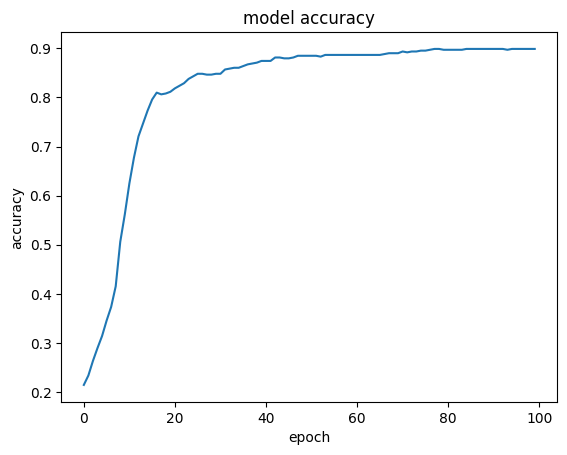

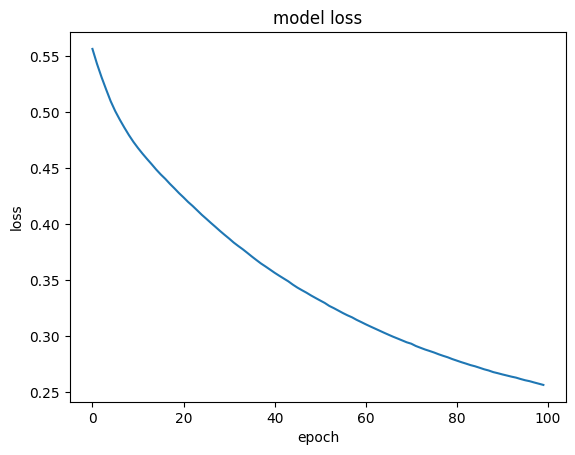

In [20]:
# Plot accuracy and loss curves

import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
# Evaluate the model on the test set and print the loss and accuracy.
model.evaluate(test_normalized, test_labels) # [loss, accuracy]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9128 - loss: 0.3221  


[0.36157599091529846, 0.904181182384491]

In [22]:
# Make predictions on the test set.
predictions = model.predict(test_normalized)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [23]:
# Print the first 5 predictions.
predictions[0:5]

array([[0.19136034, 0.80863965],
       [0.535038  , 0.4649619 ],
       [0.93959564, 0.06040432],
       [0.14479911, 0.8552009 ],
       [0.13969894, 0.860301  ]], dtype=float32)

The predictions are the probabilities for each of the classes. Thus, we need to get the class with the highest probability.

In [24]:
# Get the column index with max probability from predictions.
predictions_int = np.argmax(predictions, axis=1)

# Ground truth
true_values_int = np.argmax(test_labels, axis=1)

In [25]:
# Convert back to strings
predictions_str = le.inverse_transform(predictions_int)

true_values_str = le.inverse_transform(true_values_int)

In [26]:
pd.crosstab(true_values_str, predictions_str, rownames=['True labels'], colnames=['Predicted labels'])

Predicted labels,abnormal,normal
True labels,,
abnormal,24,4
normal,51,495


In [27]:
accuracy_score(true_values_str, predictions_str)

0.9041811846689896

In [28]:
recall_score(true_values_str, predictions_str, average=None)

array([0.85714286, 0.90659341])

# Now, train a model (without class weighting) by first oversampling the *train* data using SMOTE.

-Train a model with the same architecture as the previous one.
-Conduct your experiments below and compare the resuls between the weighted model and using SMOTE. Which method was better? Write your conclusions at the end.

In [ ]:
# YOUR CODE HERE



# Conclusions

Write your conclusions here.